In [1]:
from simtk.openmm import app
from simtk import openmm as mm
from simtk import unit

In [2]:
from openmmtools.testsystems import AlanineDipeptideImplicit

In [3]:
testsystem = AlanineDipeptideImplicit()
len(testsystem.positions)

22

In [4]:
testsystem.system.getForces()

[<simtk.openmm.openmm.HarmonicBondForce; proxy of <Swig Object of type 'OpenMM::HarmonicBondForce *' at 0x1187fcf00> >,
 <simtk.openmm.openmm.HarmonicAngleForce; proxy of <Swig Object of type 'OpenMM::HarmonicAngleForce *' at 0x1187fcf90> >,
 <simtk.openmm.openmm.PeriodicTorsionForce; proxy of <Swig Object of type 'OpenMM::PeriodicTorsionForce *' at 0x1187f3030> >,
 <simtk.openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x1187f3060> >,
 <simtk.openmm.openmm.CustomGBForce; proxy of <Swig Object of type 'OpenMM::CustomGBForce *' at 0x1187f3090> >,
 <simtk.openmm.openmm.CMMotionRemover; proxy of <Swig Object of type 'OpenMM::CMMotionRemover *' at 0x1187f30c0> >]

In [5]:
gbsa_force = testsystem.system.getForce(4)
gbsa_force

<simtk.openmm.openmm.CustomGBForce; proxy of <Swig Object of type 'OpenMM::CustomGBForce *' at 0x1180c10c0> >

In [6]:
from autograd import numpy as np
from autograd import grad


def step(x):
    return (x > 0)
    #return 1.0 * (x > 0)

# first, implement with for loops: later, vectorize
def compute_OBC_energy_reference(distance_matrix, radii, scales, charges,
                      offset, screening, surface_tension,
                      solvent_dielectric, solute_dielectric
                     ):
    N = len(radii)
    assert((len(charges) == N) and (distance_matrix.shape == (N,N)))
    
    # first, compute this intermediate value that depends on pairs
    I = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            
            if i != j:
                r = distance_matrix[i, j]
                or1 = radii[i] - offset
                or2 = radii[j] - offset
                sr2 = scales[j] * or2
                
                D = step(r - sr2) * (r - sr2) + (1 - step(r - sr2)) * (sr2 - r)
                L = step(or1 - D) * or1 + (1 - step(or1 - D)) * D
                C = 2 * ((1 / or1) - (1 / L)) * step(sr2 - r - or1)
                U = r + sr2
                I[i, j] = step(r + sr2 - or1) * 0.5 * ((1 / L) - (1 / U) + 0.25 * (1 / (U**2) - 1 / (L**2)) * (r - sr2 * sr2 / r) + 0.5 * np.log(L / U) / r + C)
    I = np.sum(I, axis=1)
    
    # okay, next compute born radii
    B = np.zeros(N)
    for i in range(N):
        offset_radius = radii[i] - offset
        psi = I[i] * offset_radius
        B[i] = 1 / (1 / offset_radius - np.tanh(1 * psi - 0.8 * psi**2 + 4.85 * psi**3) / radii[i])
    
    # finally, compute two energy terms
    E = 0
    
    # single particle
    for i in range(N):
        E += surface_tension * (radii[i] + 0.14)**2 * (radii[i] / B[i])**6 - 0.5 * screening * ((1 / solute_dielectric) - (1 / solvent_dielectric)) * charges[i]**2 / B[i]
    # particle pair
    for i in range(N):
        for j in range(i):
            r = distance_matrix[i,j]
            f = np.sqrt(r**2 + B[i] * B[j] * np.exp(-r**2 / (4*B[i]*B[j])))
            E += -screening * ((1 / solute_dielectric) - (1 / solvent_dielectric)) * charges[i] * charges[j] / f
    return E

In [7]:
N = 22
distance_matrix = np.random.rand(N, N) + 1
radii = np.random.rand(N) + 1
scales = np.random.rand(N) + 1
charges = np.random.randn(N)
offset = 0.009
screening = 138.935456
surface_tension = 28.3919551
solvent_dielectric = 70.0
solute_dielectric = 1.0

In [8]:
compute_OBC_energy_reference(distance_matrix, radii, scales, charges, offset, screening, surface_tension, solvent_dielectric, solute_dielectric)

-1.1445696187681853

In [9]:
def objective(radii):
    return compute_OBC_energy_reference(distance_matrix, radii, scales, charges, offset, screening, surface_tension, solvent_dielectric, solute_dielectric)

In [10]:
# grad(objective)(radii) # gives a value error...

In [11]:
def compute_OBC_energy_vectorized(distance_matrix, radii, scales, charges,
                      offset, screening, surface_tension,
                      solvent_dielectric, solute_dielectric
                     ):
    N = len(radii)
    assert((len(charges) == N) and (distance_matrix.shape == (N,N)))
    
    # first, compute this intermediate value that depends on pairs
    r = distance_matrix
    or1 = radii.reshape((N, 1)) - offset
    or2 = radii.reshape((1, N)) - offset
    sr2 = scales.reshape((1, N)) * or2
    D = step(r - sr2) * (r - sr2) + (1 - step(r - sr2)) * (sr2 - r)
    L = step(or1 - D) * or1 + (1 - step(or1 - D)) * D
    C = 2 * ((1 / or1) - (1 / L)) * step(sr2 - r - or1)
    U = r + sr2
    I = step(r + sr2 - or1) * 0.5 * ((1 / L) - (1 / U) + 0.25 * (1 / (U**2) - 1 / (L**2)) * (r - sr2 * sr2 / r) + 0.5 * np.log(L / U) / r + C)
    
    I -= np.diag(np.diag(I))
    I = 0.5 * np.sum(I, axis=1)
    
    # okay, next compute born radii
    offset_radius = radii - offset
    psi = I * offset_radius
    B = 1 / (1 / offset_radius - np.tanh(1 * psi - 0.8 * psi**2 + 4.85 * psi**3) / radii)
    
    # finally, compute two energy terms
    E = 0
    
    # single particle
    E += np.sum(surface_tension * (radii + 0.14)**2 * (radii / B)**6 - 0.5 * screening * ((1 / solute_dielectric) - (1 / solvent_dielectric)) * charges**2 / B)
    
    # particle pair
    f = np.sqrt(r**2 + np.outer(B, B) * np.exp(-r**2 / (4*np.outer(B, B))))
    X = - screening * ((1 / solute_dielectric) - (1 / solvent_dielectric)) * np.outer(charges, charges) / f
    E += np.sum(np.triu(X, k=1))
    return E

In [12]:
%%time
compute_OBC_energy_reference(distance_matrix, radii, scales, charges, offset, screening, surface_tension, solvent_dielectric, solute_dielectric)

CPU times: user 15 ms, sys: 475 µs, total: 15.5 ms
Wall time: 15 ms


-1.1445696187681853

In [13]:
%%time
compute_OBC_energy_vectorized(distance_matrix, radii, scales, charges, offset, screening, surface_tension, solvent_dielectric, solute_dielectric)

CPU times: user 461 µs, sys: 77 µs, total: 538 µs
Wall time: 503 µs


-1.1445892605580452

In [14]:
# ^ interesting that it's not quite the same value -- prety close, but different after 5 decimal places

In [15]:
def objective(radii):
    return compute_OBC_energy_vectorized(distance_matrix, radii, scales, charges, offset, screening, surface_tension, solvent_dielectric, solute_dielectric)

In [16]:
%%time
grad(objective)(radii)

CPU times: user 3.36 ms, sys: 165 µs, total: 3.52 ms
Wall time: 3.42 ms


array([-0.60252567, -1.35519531,  1.55331117, -0.11690208,  0.00461215,
        0.94811835,  0.07059733,  0.0872755 ,  1.29461134, -0.83346227,
       -0.2947444 , -0.04895426,  0.44994603,  0.30602013, -0.0645902 ,
        0.74996872,  0.0543421 , -0.152454  , -0.51863523, -1.26654435,
       -0.06258519,  0.52052472])

In [17]:
len(radii)

22

In [22]:
implicit_sim = app.Simulation(testsystem.topology,
                     testsystem.system,
                     mm.LangevinIntegrator(298 * unit.kelvin, 1.0 / unit.picosecond, 1.0 * unit.femtosecond),
                     platform=mm.Platform.getPlatformByName('CPU')
                    )
implicit_sim.context.setPositions(testsystem.positions)
implicit_sim.step(1)

In [23]:
%%time
implicit_sim.step(1000)

CPU times: user 1.44 s, sys: 2.62 s, total: 4.06 s
Wall time: 1.78 s


In [24]:
from tqdm import tqdm
implicit_traj = []
for _ in tqdm(range(25)):
    implicit_sim.step(1000)
    implicit_traj.append(implicit_sim.context.getState(getPositions=True).getPositions(asNumpy=True))

100%|██████████| 25/25 [00:43<00:00,  1.72s/it]


In [25]:
vacuum_testsystem = AlanineDipeptideImplicit()
vacuum_testsystem.system.removeForce(4)
vacuum_testsystem.system.getForces()

[<simtk.openmm.openmm.HarmonicBondForce; proxy of <Swig Object of type 'OpenMM::HarmonicBondForce *' at 0x118d3d780> >,
 <simtk.openmm.openmm.HarmonicAngleForce; proxy of <Swig Object of type 'OpenMM::HarmonicAngleForce *' at 0x118d3d990> >,
 <simtk.openmm.openmm.PeriodicTorsionForce; proxy of <Swig Object of type 'OpenMM::PeriodicTorsionForce *' at 0x118d3da20> >,
 <simtk.openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x118d3d0c0> >,
 <simtk.openmm.openmm.CMMotionRemover; proxy of <Swig Object of type 'OpenMM::CMMotionRemover *' at 0x118d3dae0> >]

In [26]:
vacuum_sim = app.Simulation(vacuum_testsystem.topology,
                     vacuum_testsystem.system,
                     mm.LangevinIntegrator(298 * unit.kelvin, 1.0 / unit.picosecond, 1.0 * unit.femtosecond),
                     platform=mm.Platform.getPlatformByName('Reference')
                    )
vacuum_sim.context.setPositions(vacuum_testsystem.positions)
vacuum_sim.step(1)

In [27]:
vacuum_sim.step(1000)

In [28]:
from tqdm import tqdm
vacuum_traj = []

for _ in tqdm(range(25)):
    vacuum_sim.step(1000)
    vacuum_traj.append(vacuum_sim.context.getState(getPositions=True).getPositions(asNumpy=True))

100%|██████████| 25/25 [00:02<00:00, 10.60it/s]


In [29]:
x = vacuum_traj + implicit_traj

In [30]:
from openmmtools.constants import kB
kT = kB * 298 * unit.kelvin

In [31]:
u_kn = np.zeros((2, len(x)))

for i in range(len(x)):
    vacuum_sim.context.setPositions(x[i])
    implicit_sim.context.setPositions(x[i])
    
    u_kn[0, i] = vacuum_sim.context.getState(getEnergy=True).getPotentialEnergy() / kT
    u_kn[1, i] = implicit_sim.context.getState(getEnergy=True).getPotentialEnergy() / kT

In [32]:
import pymbar
mbar = pymbar.MBAR(u_kn, [len(vacuum_traj)]*2)

In [33]:
mbar.f_k

array([  0.        , -22.99101193])

In [34]:
[m[0,1] for m in mbar.getFreeEnergyDifferences()[:2]]

[-22.991011933207375, 0.256170433381466]

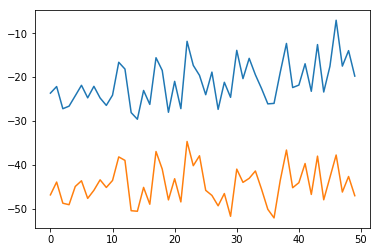

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(u_kn[0])
plt.plot(u_kn[1])

In [36]:
N = len(vacuum_traj)

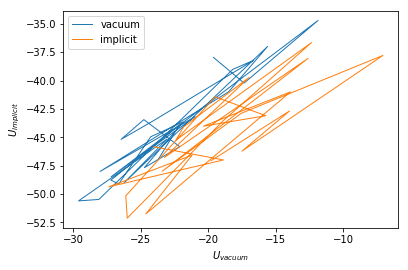

In [37]:
plt.plot(u_kn[0][:N], u_kn[1][:N], linewidth=1, label='vacuum')
plt.plot(u_kn[0][N:], u_kn[1][N:], linewidth=1, label='implicit')
plt.xlabel(r'$U_{vacuum}$')
plt.ylabel(r'$U_{implicit}$')
plt.legend(loc='best')

In [38]:
vacuum_xyz = np.array([frame.value_in_unit(unit.nanometer) for frame in vacuum_traj])
implicit_xyz = np.array([frame.value_in_unit(unit.nanometer) for frame in implicit_traj])

In [39]:
import mdtraj as md
md_top = md.Topology().from_openmm(testsystem.topology)
vacuum_md_traj = md.Trajectory(vacuum_xyz, md_top)
implicit_md_traj = md.Trajectory(implicit_xyz, md_top)

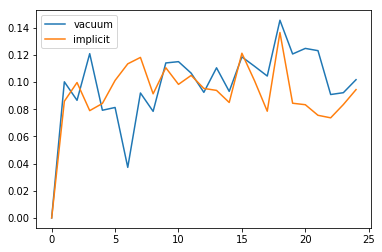

In [40]:
plt.plot(md.rmsd(vacuum_md_traj, vacuum_md_traj), label='vacuum')
plt.plot(md.rmsd(implicit_md_traj, implicit_md_traj), label='implicit')
plt.legend(loc='best')

In [41]:
vacuum_Us = []
for i in range(len(x)):
    vacuum_sim.context.setPositions(x[i])
    vacuum_Us.append(vacuum_sim.context.getState(getEnergy=True).getPotentialEnergy())

In [42]:
implicit_only = AlanineDipeptideImplicit()
implicit_only.system.removeForce(0)
implicit_only.system.removeForce(0)
implicit_only.system.removeForce(0)
implicit_only.system.removeForce(0)
implicit_only.system.removeForce(1)
implicit_only.system.getForces()

[<simtk.openmm.openmm.CustomGBForce; proxy of <Swig Object of type 'OpenMM::CustomGBForce *' at 0x11d135390> >]

In [43]:
implicit_only_sim = app.Simulation(testsystem.topology,
                     implicit_only.system,
                     mm.LangevinIntegrator(298 * unit.kelvin, 1.0 / unit.picosecond, 1.0 * unit.femtosecond),
                     platform=mm.Platform.getPlatformByName('CPU')
                    )
implicit_only_sim.context.setPositions(testsystem.positions)

In [44]:
implicit_only_Us = []
for i in range(len(x)):
    implicit_only_sim.context.setPositions(x[i])
    implicit_only_Us.append(implicit_only_sim.context.getState(getEnergy=True).getPotentialEnergy())

In [45]:
implicit_only_Us[0]

Quantity(value=-57.494387954473495, unit=kilojoule/mole)

In [46]:
combined_us = np.array([(implicit_only_Us[i] + vacuum_Us[i]) / kT for i in range(len(x))])
np.linalg.norm(combined_us - u_kn[1])

8.391757785644775e-05

In [47]:
from scipy.spatial.distance import pdist, squareform

In [48]:
def precompute_distance_matrices(x):
    return [squareform(pdist(snapshot)) + np.eye(len(snapshot)) for snapshot in x]

In [49]:
%%time
distance_matrices = precompute_distance_matrices(x)

CPU times: user 3.56 ms, sys: 1.71 ms, total: 5.27 ms
Wall time: 3.74 ms


In [50]:
radii = []
charges = []
scales = []
for i in range(gbsa_force.getNumPerParticleParameters()):
    print(gbsa_force.getPerParticleParameterName(i))

for i in range(gbsa_force.getNumParticles()):
    charge, o_r, s_r = gbsa_force.getParticleParameters(i)
    radii.append(o_r)
    charges.append(charge)
    scales.append(s_r / o_r)

charge
or
sr


In [51]:
radii = np.array(radii)
charges = np.array(charges)
scales = np.array(scales)
radii, charges, scales

(array([0.111, 0.161, 0.111, 0.111, 0.161, 0.141, 0.146, 0.121, 0.161,
        0.111, 0.161, 0.111, 0.111, 0.111, 0.161, 0.141, 0.146, 0.121,
        0.161, 0.111, 0.111, 0.111]),
 array([ 0.1123, -0.3662,  0.1123,  0.1123,  0.5972, -0.5679, -0.4157,
         0.2719,  0.0337,  0.0823, -0.1825,  0.0603,  0.0603,  0.0603,
         0.5973, -0.5679, -0.4157,  0.2719, -0.149 ,  0.0976,  0.0976,
         0.0976]),
 array([0.85, 0.72, 0.85, 0.85, 0.72, 0.85, 0.79, 0.85, 0.72, 0.85, 0.72,
        0.85, 0.85, 0.85, 0.72, 0.85, 0.79, 0.85, 0.72, 0.85, 0.85, 0.85]))

In [52]:
gbsa_force.getParticleParameters(0)

(0.1123, 0.111, 0.09435)

In [53]:
offset = 0.009
screening = 138.935456
surface_tension = 28.3919551
solvent_dielectric = 70.0
solute_dielectric = 1.0

In [54]:
distance_matrices[0].shape

(22, 22)

In [55]:
compute_OBC_energy_vectorized(distance_matrix, radii, scales, charges,
                      offset, screening, surface_tension,
                      solvent_dielectric, solute_dielectric)

-867.5996239579484

In [56]:
autograd_energies = [compute_OBC_energy_vectorized(distance_matrix, radii, scales, charges,
                      offset, screening, surface_tension,
                      solvent_dielectric, solute_dielectric) for distance_matrix in distance_matrices]

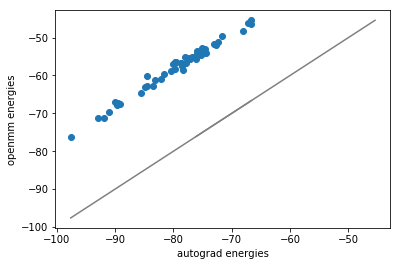

In [57]:
openmm_energies = [v.value_in_unit(unit.kilojoule_per_mole) for v in implicit_only_Us]
plt.scatter(autograd_energies, openmm_energies)
plt.xlabel('autograd energies')
plt.ylabel('openmm energies')
plt.plot(sorted(autograd_energies), sorted(autograd_energies), color='grey')
plt.plot(sorted(openmm_energies), sorted(openmm_energies), color='grey')

In [58]:
# okay can probably ignore that, and hope that I'm just missing some additive factor?

In [59]:
from autograd.scipy.misc import logsumexp

def compute_perturbed_free_energies(mbar, u_ln):
    
    states_with_samples = (mbar.N_k > 0)
    log_q_k = mbar.f_k[states_with_samples] - mbar.u_kn[states_with_samples].T
    log_denominator_n = logsumexp(log_q_k, b=mbar.N_k[states_with_samples], axis=1)
    
    return logsumexp(-u_ln[:len(u_ln)] - log_denominator_n, axis=1)

In [60]:
N = 22

In [61]:
def unpack_theta(theta):
    assert(len(theta) == ((2 * N) + 3))
    radii = theta[:N]
    scales = theta[N:2*N]
    offset, screening, surface_tension = theta[2*N:]
    return radii, scales, offset, screening, surface_tension

def pack_theta(radii, scales, offset, screening, surface_tension):
    theta = np.zeros(((2 * N) + 3))
    theta[:N] = radii
    theta[N:2*N] = scales
    theta[2*N:] = (offset, screening, surface_tension)
    return theta

In [62]:
theta = pack_theta(radii, scales, offset, screening, surface_tension)
theta

array([1.11000000e-01, 1.61000000e-01, 1.11000000e-01, 1.11000000e-01,
       1.61000000e-01, 1.41000000e-01, 1.46000000e-01, 1.21000000e-01,
       1.61000000e-01, 1.11000000e-01, 1.61000000e-01, 1.11000000e-01,
       1.11000000e-01, 1.11000000e-01, 1.61000000e-01, 1.41000000e-01,
       1.46000000e-01, 1.21000000e-01, 1.61000000e-01, 1.11000000e-01,
       1.11000000e-01, 1.11000000e-01, 8.50000000e-01, 7.20000000e-01,
       8.50000000e-01, 8.50000000e-01, 7.20000000e-01, 8.50000000e-01,
       7.90000000e-01, 8.50000000e-01, 7.20000000e-01, 8.50000000e-01,
       7.20000000e-01, 8.50000000e-01, 8.50000000e-01, 8.50000000e-01,
       7.20000000e-01, 8.50000000e-01, 7.90000000e-01, 8.50000000e-01,
       7.20000000e-01, 8.50000000e-01, 8.50000000e-01, 8.50000000e-01,
       9.00000000e-03, 1.38935456e+02, 2.83919551e+01])

In [63]:
radii.shape, N

((22,), 22)

In [64]:
def compute_u_ln(theta):
    radii, scales, offset, screening, surface_tension = unpack_theta(theta)
    
    
    u_new = np.array([compute_OBC_energy_vectorized(distance_matrix, radii, scales, charges,
                      offset, screening, surface_tension,
                      solvent_dielectric, solute_dielectric)
                      for distance_matrix in distance_matrices]).reshape((1, len(distance_matrices)))
    u_ln = np.vstack([u_kn, u_new])
    return u_ln

In [65]:
u_ln = compute_u_ln(theta)

In [66]:
u_ln.shape

(3, 50)

In [67]:
f_k = compute_perturbed_free_energies(mbar, u_ln)

In [68]:
f_k[:2]

array([-1.33226763e-15,  2.29910119e+01])

In [69]:
f_k[0]

-1.3322676295501878e-15

In [70]:
f_k[-1]

79.60984614246634

In [71]:
f_k

array([-1.33226763e-15,  2.29910119e+01,  7.96098461e+01])

In [72]:
def loss(theta):
    u_ln = compute_u_ln(theta)
    f_k = compute_perturbed_free_energies(mbar, u_ln)
    if np.sum(np.isnan(f_k)) > 0:
        return np.inf
    else:
        return (f_k[1] - f_k[2])**2

In [73]:
loss(theta)

3205.692387215553

In [74]:
%%time
grad(loss)(theta)

CPU times: user 242 ms, sys: 10.3 ms, total: 252 ms
Wall time: 247 ms


array([-3.35041373e+03, -5.51860588e+03, -2.67571172e+03, -3.94428943e+03,
       -6.19962163e+03, -8.03846339e+04, -8.31786765e+03, -1.90607398e+04,
       -4.43557164e+03, -5.92184590e+03,  1.24218438e+02, -1.18166330e+03,
       -1.34576051e+03, -5.44562004e+02, -1.31035631e+04, -8.07644448e+04,
       -1.40166046e+04, -2.00112387e+04, -4.74115453e+03, -2.85594471e+03,
       -3.45253216e+03, -2.61548863e+03,  4.13241883e+01, -1.30747901e+02,
        1.77237363e+01,  7.43936729e+01, -6.57158481e+02,  1.07805901e+02,
       -4.77632407e+02,  1.22577967e+02, -3.27727391e+02, -1.75898225e+01,
        3.52892370e+02,  1.10568307e+02,  1.23766322e+02,  1.38345081e+02,
       -7.04902099e+02,  8.23938814e+00, -3.02009010e+02,  5.68426367e+01,
        4.42931302e+01,  5.63413268e+01,  6.12010611e+01,  3.54712302e+00,
        4.92523895e+04,  1.11362993e+02, -1.55638702e+02])

In [75]:
g = grad(loss)(theta)

In [76]:
np.linalg.norm(g)

129705.88642250524

In [77]:
from tqdm import tqdm
def langevin(x, v, force, n_steps=100, stepsize=0.01, collision_rate=1e-5, reduced_temperature=1):
    
    x = np.array(x)
    v = np.array(v)
    traj = [np.array(x)]
    
    energies = [loss(x)]
    
    a = np.exp(- collision_rate * stepsize)
    b = np.sqrt(1 - np.exp(-2 * collision_rate * stepsize))
    
    F = force(x)
    #print(F)
    
    trange = tqdm(range(n_steps))
    for _ in trange:
        # v
        v += (stepsize * 0.5) * F
        # r
        x += (stepsize * 0.5) * v
        # o
        v = (a * v) + (b * np.random.randn(*x.shape) * reduced_temperature)
        # r
        x += (stepsize * 0.5) * v
        
        F = force(x)
        # v
        v += (stepsize * 0.5) * F
        
        energy = loss(x)
        trange.set_postfix({'energy': energy})
        #print(energy)
        
        if (np.sum(np.isfinite(x)) != len(x)) or (not np.isfinite(energy)):
            print("Numerical instability encountered!")
            return np.array(traj), np.array(energies)
        
        traj.append(np.array(x))
        energies.append(energy)

    return np.array(traj), np.array(energies)

In [78]:
def force(x):
    return -grad(loss)(x)

In [79]:
from scipy.optimize import minimize
result = minimize(loss, theta,
                  jac=grad(loss),
                  tol=0.1,
                  options={'disp': True, 'maxiter': 10})

/Users/joshuafass/anaconda/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
/Users/joshuafass/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/Users/joshuafass/anaconda/lib/python3.6/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")
/Users/joshuafass/anaconda/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
/Users/joshuafass/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/Users/joshuafass/anaconda/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  r

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 8
         Function evaluations: 49
         Gradient evaluations: 27


In [80]:
np.linalg.norm(force(result.x)), np.linalg.norm(force(theta))

(0.012009637782715049, 129705.88642250524)

In [81]:
np.random.seed(0)
x = result.x
v = np.random.randn(len(theta))
stepsize = 0.001
collision_rate = 1.0 / stepsize
traj, energies = langevin(x, v, force, n_steps=1000, stepsize=stepsize, collision_rate=collision_rate, reduced_temperature=0.1)

100%|██████████| 1000/1000 [03:55<00:00,  4.41it/s, energy=0.00549]


In [82]:
traj.shape

(1001, 47)

In [83]:
loss(theta)

3205.692387215553

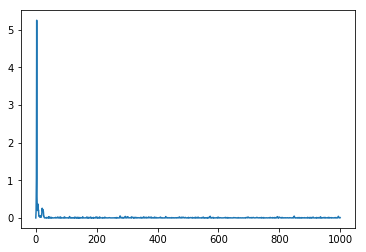

In [84]:
plt.plot(energies)

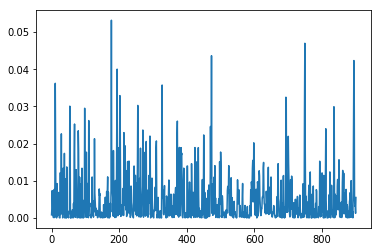

In [85]:
plt.plot(energies[100:])

/Users/joshuafass/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/joshuafass/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


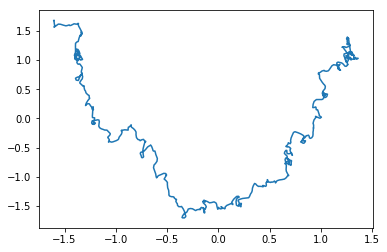

In [86]:
from msmbuilder.decomposition import tICA

tica = tICA()
y = tica.fit_transform([traj[100:]])[0]

plt.plot(y[:,0], y[:,1])

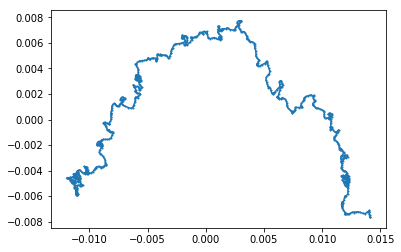

In [87]:
from sklearn.decomposition import PCA

pca = PCA()
y = pca.fit_transform(traj[100:])
plt.plot(y[:,0], y[:,1])
plt.scatter(y[:,0], y[:,1], s=1)

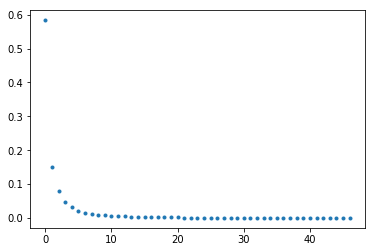

In [88]:
plt.plot(pca.explained_variance_ratio_, '.')

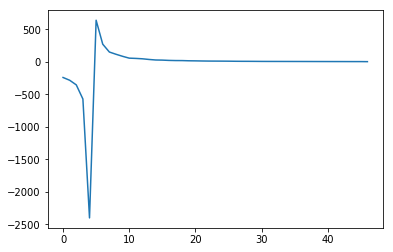

In [89]:
plt.plot(tica.timescales_)

In [90]:
np.linalg.norm(result.x - theta)

0.2460432017933547

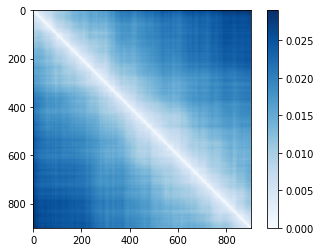

In [91]:
plt.imshow(squareform(pdist(traj[100:])), cmap='Blues')
plt.colorbar()

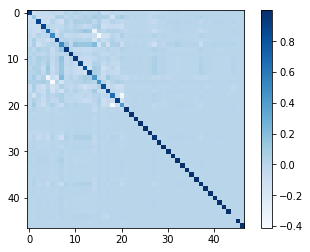

In [92]:
plt.imshow(result.hess_inv, cmap='Blues')
plt.colorbar()

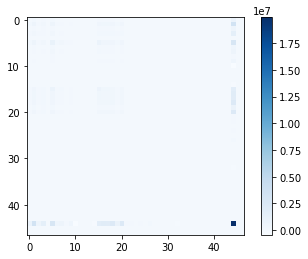

In [93]:
plt.imshow(np.linalg.pinv(result.hess_inv), cmap='Blues')
plt.colorbar()

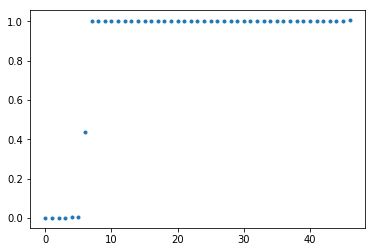

In [94]:
plt.plot(np.linalg.eigvalsh(result.hess_inv), '.')

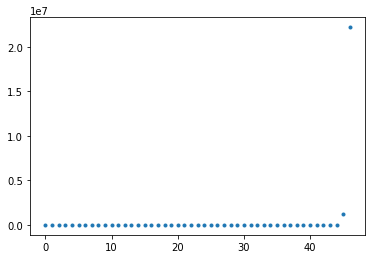

In [95]:
plt.plot(np.linalg.eigvalsh(np.linalg.inv(result.hess_inv)), '.')

In [96]:
np.linalg.cond(result.hess_inv)

22322339.505555984

In [97]:
samples = traj[100:]

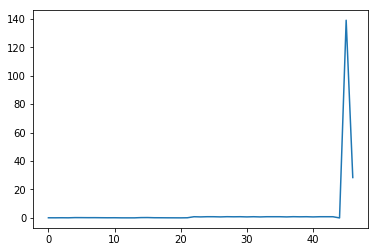

In [98]:
plt.plot(samples.mean(0))

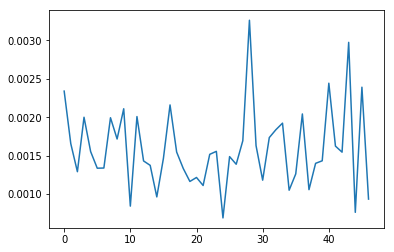

In [99]:
plt.plot(samples.std(0))

In [100]:
cov = pca.get_covariance()

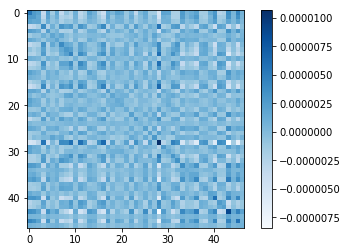

In [101]:
plt.imshow(cov, cmap='Blues')
plt.colorbar()

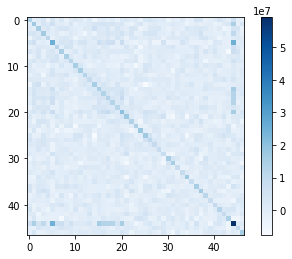

In [102]:
plt.imshow(np.linalg.pinv(cov), cmap='Blues')
plt.colorbar()

In [103]:
np.linalg.cond(cov)

7983.0074318765255

In [104]:
offset, screening, surface_tension = traj[-1][-3:]

In [136]:
# now lets hold the global parameters constant and sample over the local parameters...

u_kn_ = u_kn[:,::5]
mbar_ = pymbar.MBAR(u_kn_, [len(vacuum_traj[::5])]*2)
distance_matrices_ = distance_matrices[::5]

def pack_theta(radii, scales):
    theta = np.zeros((2 * N))
    theta[:N] = radii
    theta[N:2*N] = scales
    return theta

def unpack_theta(theta):
    assert(len(theta) == (2 * N))
    radii = theta[:N]
    scales = theta[N:2*N]
    return radii, scales

def compute_u_ln(theta):
    radii, scales = unpack_theta(theta)
    
    u_new = np.array([compute_OBC_energy_vectorized(distance_matrix, radii, scales, charges,
                      offset, screening, surface_tension,
                      solvent_dielectric, solute_dielectric)
                      for distance_matrix in distance_matrices_]).reshape((1, len(distance_matrices_)))
    u_ln = np.vstack([u_kn_, u_new])
    return u_ln

def loss(theta):
    u_ln = compute_u_ln(theta)
    f_k = compute_perturbed_free_energies(mbar_, u_ln)
    if np.sum(np.isnan(f_k)) > 0:
        return np.inf
    else:
        return (f_k[1] - f_k[2])**2
    
def force(x):
    return -grad(loss)(x)

In [106]:
x0 = traj[-1][:2*N]

In [163]:
np.random.seed(0)
v0 = np.random.randn(len(x0)) * 0.1
stepsize = 0.0005
collision_rate = 1.0 / stepsize
traj, energies = langevin(x0, v0, force, n_steps=100000,
                          stepsize=stepsize,
                          collision_rate=collision_rate)


  0%|          | 336/100000 [00:16<1:17:57, 21.31it/s, energy=0.425] 


  1%|          | 672/100000 [00:31<1:23:41, 19.78it/s, energy=0.416]


  1%|          | 1008/100000 [00:48<1:07:32, 24.42it/s, energy=0.351]


  1%|▏         | 1341/100000 [01:03<1:27:15, 18.84it/s, energy=0.0605]


  2%|▏         | 1660/100000 [01:19<1:14:41, 21.94it/s, energy=0.357]


  2%|▏         | 1993/100000 [01:35<1:14:02, 22.06it/s, energy=0.076]


  2%|▏         | 2323/100000 [01:50<1:09:51, 23.31it/s, energy=0.103]


  3%|▎         | 2653/100000 [02:05<1:20:00, 20.28it/s, energy=0.609] 


  3%|▎         | 2983/100000 [02:22<1:37:06, 16.65it/s, energy=0.0983]


  3%|▎         | 3316/100000 [02:37<1:21:53, 19.68it/s, energy=0.23] 


  4%|▎         | 3648/100000 [02:52<1:02:56, 25.52it/s, energy=0.598] 


  4%|▍         | 3981/100000 [03:08<1:17:24, 20.67it/s, energy=0.00974]


  4%|▍         | 4314/100000 [03:23<1:07:44, 23.54it/s, energy=0.00931]


  5%|▍         | 4647/100000 [03:38<1:06:39, 23.84it/s, energy=0.02]


  5%|▍         | 4977/100000 [03:53<1:15:44, 20.91it/s, energy=0.865]


  5%|▌         | 5310/100000 [04:08<1:25:47, 18.39it/s, energy=0.732]


  6%|▌         | 5643/100000 [04:23<1:01:39, 25.50it/s, energy=0.0892]


  6%|▌         | 5976/100000 [04:38<1:01:30, 25.48it/s, energy=0.371]


  6%|▋         | 6309/100000 [04:53<1:02:36, 24.94it/s, energy=0.0525]


  7%|▋         | 6642/100000 [05:08<1:09:33, 22.37it/s, energy=0.109]


  7%|▋         | 6975/100000 [05:23<1:02:47, 24.69it/s, energy=0.632]


  7%|▋         | 7308/100000 [05:39<1:03:05, 24.49it/s, energy=0.777]


  8%|▊         | 7641/100000 [05:54<1:04:35, 23.83it/s, energy=0.262]


  8%|▊         | 7974/100000 [06:09<1:00:45, 25.24it/s, energy=0.157] 


  8%|▊         | 8307/100000 [06:24<59:57, 25.49it/s, energy=0.125] 


  9%|▊         | 8640/100000 [06:39<1:20:17, 18.96it/s, energy=0.16] 


  9%|▉         | 8973/100000 [06:54<1:13:14, 20.72it/s, energy=0.228]


  9%|▉         | 9303/100000 [07:09<1:20:55, 18.68it/s, energy=0.252] 


 10%|▉         | 9636/100000 [07:24<1:12:42, 20.72it/s, energy=0.548]


 10%|▉         | 9969/100000 [07:40<1:24:01, 17.86it/s, energy=0.135]


 10%|█         | 10299/100000 [07:55<1:10:06, 21.33it/s, energy=1.5] 


 11%|█         | 10629/100000 [08:10<1:18:15, 19.03it/s, energy=34.8]


 11%|█         | 10959/100000 [08:25<1:11:12, 20.84it/s, energy=0.00239]


 11%|█▏        | 11289/100000 [08:40<1:19:00, 18.71it/s, energy=0.929]


 12%|█▏        | 11616/100000 [08:54<58:24, 25.22it/s, energy=0.0552] 


 12%|█▏        | 11946/100000 [09:09<1:00:14, 24.36it/s, energy=0.0425]


 12%|█▏        | 12276/100000 [09:24<1:03:14, 23.12it/s, energy=0.811] 


 13%|█▎        | 12603/100000 [09:39<1:15:41, 19.25it/s, energy=0.0189]


 13%|█▎        | 12933/100000 [09:54<56:48, 25.54it/s, energy=0.855]


 13%|█▎        | 13263/100000 [10:09<1:01:30, 23.50it/s, energy=0.841]


 14%|█▎        | 13590/100000 [10:24<1:01:40, 23.35it/s, energy=0.241] 


 14%|█▍        | 13917/100000 [10:39<1:08:14, 21.03it/s, energy=0.232]


 14%|█▍        | 14244/100000 [10:55<1:07:54, 21.05it/s, energy=0.102] 


 15%|█▍        | 14571/100000 [11:11<1:18:24, 18.16it/s, energy=1.56]


 15%|█▍        | 14898/100000 [11:26<59:03, 24.01it/s, energy=0.0024]


 15%|█▌        | 15225/100000 [11:41<1:01:29, 22.98it/s, energy=0.112]


 16%|█▌        | 15555/100000 [11:57<1:07:22, 20.89it/s, energy=0.632]   


 16%|█▌        | 15885/100000 [12:12<1:15:16, 18.62it/s, energy=3.57]


 16%|█▌        | 16212/100000 [12:27<58:50, 23.73it/s, energy=0.251]   


 17%|█▋        | 16542/100000 [12:43<1:06:57, 20.77it/s, energy=1.29]


 17%|█▋        | 16872/100000 [12:58<1:08:16, 20.29it/s, energy=0.461] 


 17%|█▋        | 17202/100000 [13:13<1:09:09, 19.96it/s, energy=0.0735]  


 18%|█▊        | 17529/100000 [13:29<1:15:49, 18.13it/s, energy=0.102]


 18%|█▊        | 17859/100000 [13:44<56:03, 24.42it/s, energy=1.62] 


 18%|█▊        | 18189/100000 [14:00<59:26, 22.94it/s, energy=0.104]   


 19%|█▊        | 18519/100000 [14:16<1:03:29, 21.39it/s, energy=0.426]


 19%|█▉        | 18849/100000 [14:31<1:11:40, 18.87it/s, energy=0.183] 


 19%|█▉        | 19179/100000 [14:47<59:21, 22.69it/s, energy=0.322]  


 20%|█▉        | 19509/100000 [15:02<54:15, 24.72it/s, energy=0.0209]  


 20%|█▉        | 19839/100000 [15:18<1:15:13, 17.76it/s, energy=1.57]


 20%|██        | 20169/100000 [15:33<53:52, 24.70it/s, energy=0.304]


 20%|██        | 20499/100000 [15:48<59:53, 22.12it/s, energy=0.00489]


 21%|██        | 20826/100000 [16:05<1:06:53, 19.73it/s, energy=0.0294]


 21%|██        | 21156/100000 [16:20<1:15:03, 17.51it/s, energy=0.409]


 21%|██▏       | 21486/100000 [16:36<55:29, 23.58it/s, energy=0.102]


 22%|██▏       | 21770/100000 [16:53<2:53:54,  7.50it/s, energy=0.154] 


 22%|██▏       | 21952/100000 [17:11<59:52, 21.72it/s, energy=0.0598]  


 22%|██▏       | 22279/100000 [17:28<1:12:44, 17.81it/s, energy=0.626]


 23%|██▎       | 22609/100000 [17:43<51:24, 25.09it/s, energy=0.237]


 23%|██▎       | 22938/100000 [17:59<1:09:48, 18.40it/s, energy=0.0953]


 23%|██▎       | 23267/100000 [18:15<56:33, 22.61it/s, energy=0.675]


 24%|██▎       | 23600/100000 [18:30<50:12, 25.36it/s, energy=0.0436]


 24%|██▍       | 23928/100000 [18:46<54:17, 23.35it/s, energy=0.556]


 24%|██▍       | 24254/100000 [19:02<1:07:19, 18.75it/s, energy=0.018]


 25%|██▍       | 24576/100000 [19:19<55:36, 22.60it/s, energy=0.0579] 


 25%|██▍       | 24909/100000 [19:34<1:00:30, 20.68it/s, energy=0.046]


 25%|██▌       | 25242/100000 [19:50<59:30, 20.94it/s, energy=0.809] 


 26%|██▌       | 25575/100000 [20:05<1:02:57, 19.70it/s, energy=0.0287]


 26%|██▌       | 25911/100000 [20:20<54:49, 22.52it/s, energy=0.817]


 26%|██▌       | 26244/100000 [20:36<1:00:44, 20.24it/s, energy=0.0369] 


 27%|██▋       | 26577/100000 [20:51<56:39, 21.60it/s, energy=0.881]


 27%|██▋       | 26910/100000 [21:07<1:00:45, 20.05it/s, energy=0.405]


 27%|██▋       | 27243/100000 [21:23<1:04:35, 18.77it/s, energy=0.386]


 28%|██▊       | 27576/100000 [21:38<58:14, 20.73it/s, energy=0.219]   


 28%|██▊       | 27909/100000 [21:54<1:07:18, 17.85it/s, energy=0.00965]


 28%|██▊       | 28242/100000 [22:10<1:04:27, 18.55it/s, energy=8.05]


 29%|██▊       | 28575/100000 [22:25<56:04, 21.23it/s, energy=0.0534]


 29%|██▉       | 28907/100000 [22:42<49:16, 24.05it/s, energy=0.198]


 29%|██▉       | 29226/100000 [22:59<1:09:35, 16.95it/s, energy=1.14]


 30%|██▉       | 29558/100000 [23:15<48:19, 24.30it/s, energy=0.229]


 30%|██▉       | 29891/100000 [23:31<49:01, 23.83it/s, energy=0.313]


 30%|███       | 30220/100000 [23:47<1:12:40, 16.00it/s, energy=0.0905]


 31%|███       | 30553/100000 [24:03<1:00:56, 18.99it/s, energy=0.361]


 31%|███       | 30885/100000 [24:19<1:01:42, 18.67it/s, energy=0.519]


 31%|███       | 31218/100000 [24:36<1:04:23, 17.80it/s, energy=0.0133]


 32%|███▏      | 31551/100000 [24:52<1:01:18, 18.61it/s, energy=1.56]  


 32%|███▏      | 31887/100000 [25:07<1:04:09, 17.70it/s, energy=0.905]


 32%|███▏      | 32220/100000 [25:23<54:09, 20.86it/s, energy=0.247]   


 33%|███▎      | 32553/100000 [25:38<49:50, 22.55it/s, energy=0.375]   


 33%|███▎      | 32886/100000 [25:54<45:48, 24.42it/s, energy=0.089]


 33%|███▎      | 33212/100000 [26:11<53:55, 20.64it/s, energy=0.0576]


 34%|███▎      | 33545/100000 [26:27<50:40, 21.86it/s, energy=2.25]  


 34%|███▍      | 33881/100000 [26:43<48:10, 22.88it/s, energy=0.848]


 34%|███▍      | 34217/100000 [26:58<45:34, 24.06it/s, energy=0.933]


 35%|███▍      | 34553/100000 [27:14<47:02, 23.18it/s, energy=1.07] 


 35%|███▍      | 34889/100000 [27:30<1:00:26, 17.96it/s, energy=0.784]


 35%|███▌      | 35225/100000 [27:46<54:45, 19.72it/s, energy=0.611] 


 36%|███▌      | 35561/100000 [28:02<47:28, 22.62it/s, energy=0.114] 


 36%|███▌      | 35897/100000 [28:18<46:13, 23.11it/s, energy=0.0641]


 36%|███▌      | 36233/100000 [28:34<52:34, 20.22it/s, energy=0.242]


 37%|███▋      | 36569/100000 [28:50<58:47, 17.98it/s, energy=0.319]


 37%|███▋      | 36905/100000 [29:06<44:20, 23.72it/s, energy=0.00856]


 37%|███▋      | 37241/100000 [29:22<44:48, 23.34it/s, energy=4.87e-06]


 38%|███▊      | 37577/100000 [29:38<43:01, 24.18it/s, energy=0.143] 


 38%|███▊      | 37908/100000 [29:55<59:05, 17.51it/s, energy=0.343] 


 38%|███▊      | 38243/100000 [30:11<43:46, 23.51it/s, energy=0.689]  


 39%|███▊      | 38579/100000 [30:27<52:30, 19.49it/s, energy=0.0103]


 39%|███▉      | 38915/100000 [30:43<53:50, 18.91it/s, energy=0.0245]


 39%|███▉      | 39230/100000 [31:00<49:02, 20.65it/s, energy=1.82]  


 40%|███▉      | 39559/100000 [31:17<49:28, 20.36it/s, energy=0.295]  


 40%|███▉      | 39895/100000 [31:33<40:50, 24.52it/s, energy=3.35]  


 40%|████      | 40229/100000 [31:50<54:02, 18.43it/s, energy=0.000971]


 41%|████      | 40565/100000 [32:06<53:18, 18.58it/s, energy=1.17] 


 41%|████      | 40900/100000 [32:21<47:56, 20.54it/s, energy=0.567]  


 41%|████      | 41236/100000 [32:37<44:37, 21.94it/s, energy=1.99] 


 42%|████▏     | 41571/100000 [32:53<47:06, 20.67it/s, energy=0.124]


 42%|████▏     | 41896/100000 [33:10<38:50, 24.93it/s, energy=0.798]


 42%|████▏     | 42234/100000 [33:25<54:34, 17.64it/s, energy=0.0488]


 43%|████▎     | 42528/100000 [42:30<2:33:10,  6.25it/s, energy=0.762]


 43%|████▎     | 42764/100000 [42:49<2:50:38,  5.59it/s, energy=0.476]


 43%|████▎     | 42952/100000 [43:12<1:18:55, 12.05it/s, energy=0.589]


 43%|████▎     | 43159/100000 [43:37<2:08:15,  7.39it/s, energy=0.189]


 43%|████▎     | 43413/100000 [44:00<40:40, 23.19it/s, energy=1.05] 


 44%|████▎     | 43749/100000 [44:16<53:37, 17.48it/s, energy=0.05]  


 44%|████▍     | 44061/100000 [2:01:27<43:50, 21.27it/s, energy=0.141]


 44%|████▍     | 44388/100000 [2:01:43<42:42, 21.70it/s, energy=0.504]


 45%|████▍     | 44718/100000 [2:01:59<1:00:26, 15.25it/s, energy=0.624]


 45%|████▌     | 45052/100000 [2:02:15<37:56, 24.14it/s, energy=1.56]


 45%|████▌     | 45381/100000 [2:02:31<42:27, 21.44it/s, energy=0.0248]


 46%|████▌     | 45703/100000 [2:02:47<49:15, 18.37it/s, energy=0.94] 


 46%|████▌     | 46030/100000 [2:03:03<39:01, 23.05it/s, energy=0.196]


 46%|████▋     | 46357/100000 [2:03:18<36:52, 24.24it/s, energy=0.496]


 47%|████▋     | 46684/100000 [2:03:33<47:27, 18.72it/s, energy=0.168] 


 47%|████▋     | 47011/100000 [2:03:48<40:57, 21.56it/s, energy=0.567] 


 47%|████▋     | 47338/100000 [2:04:04<38:12, 22.97it/s, energy=0.99] 


 48%|████▊     | 47665/100000 [2:04:19<43:43, 19.95it/s, energy=0.225]


 48%|████▊     | 47992/100000 [2:04:35<41:01, 21.13it/s, energy=0.0389]


 48%|████▊     | 48319/100000 [2:04:50<37:08, 23.19it/s, energy=0.0393]


 49%|████▊     | 48646/100000 [2:05:05<37:20, 22.92it/s, energy=0.138]   


 49%|████▉     | 48973/100000 [2:05:21<44:46, 18.99it/s, energy=0.505]


 49%|████▉     | 49300/100000 [2:05:36<40:15, 20.99it/s, energy=0.943]


 50%|████▉     | 49627/100000 [2:05:52<41:40, 20.14it/s, energy=0.302]


 50%|████▉     | 49954/100000 [2:06:07<38:26, 21.70it/s, energy=0.392]


 50%|█████     | 50281/100000 [2:06:23<36:26, 22.74it/s, energy=0.0881]


 51%|█████     | 50608/100000 [2:06:38<36:51, 22.34it/s, energy=0.0214]


 51%|█████     | 50935/100000 [2:06:53<31:51, 25.67it/s, energy=0.892]


 51%|█████▏    | 51262/100000 [2:07:08<34:28, 23.56it/s, energy=0.000168]


 52%|█████▏    | 51589/100000 [2:07:23<36:50, 21.90it/s, energy=0.519]


 52%|█████▏    | 51916/100000 [2:07:37<38:58, 20.56it/s, energy=1.06]


 52%|█████▏    | 52243/100000 [2:07:52<43:17, 18.39it/s, energy=0.0199]


 53%|█████▎    | 52570/100000 [2:08:08<42:39, 18.53it/s, energy=0.0913]


 53%|█████▎    | 52897/100000 [2:08:23<40:11, 19.53it/s, energy=0.0246]


 53%|█████▎    | 53224/100000 [2:08:38<42:15, 18.45it/s, energy=1.41e-06]


 54%|█████▎    | 53551/100000 [2:08:53<31:34, 24.52it/s, energy=1.87]  


 54%|█████▍    | 53878/100000 [2:09:08<36:51, 20.86it/s, energy=0.011] 


 54%|█████▍    | 54205/100000 [2:09:23<30:38, 24.91it/s, energy=0.064] 


 55%|█████▍    | 54532/100000 [2:09:38<31:47, 23.84it/s, energy=0.0146]


 55%|█████▍    | 54859/100000 [2:09:53<40:10, 18.73it/s, energy=0.0313]


 55%|█████▌    | 55186/100000 [2:10:08<32:58, 22.66it/s, energy=0.403]


 56%|█████▌    | 55513/100000 [2:10:23<39:07, 18.95it/s, energy=0.499]


 56%|█████▌    | 55840/100000 [2:10:38<30:47, 23.91it/s, energy=0.195] 


 56%|█████▌    | 56167/100000 [2:10:53<35:03, 20.84it/s, energy=0.455]  


 56%|█████▋    | 56494/100000 [2:11:08<28:17, 25.63it/s, energy=0.301]


 57%|█████▋    | 56821/100000 [2:11:23<29:20, 24.53it/s, energy=0.00337]


 57%|█████▋    | 57148/100000 [2:11:38<30:00, 23.80it/s, energy=0.00435]


 57%|█████▋    | 57475/100000 [2:11:53<34:22, 20.62it/s, energy=0.312]


 58%|█████▊    | 57802/100000 [2:12:08<29:48, 23.59it/s, energy=0.152]


 58%|█████▊    | 58129/100000 [2:12:23<33:55, 20.57it/s, energy=0.00658]


 58%|█████▊    | 58456/100000 [2:12:37<29:06, 23.78it/s, energy=0.458]


 59%|█████▉    | 58783/100000 [2:12:52<27:46, 24.74it/s, energy=0.0325]


 59%|█████▉    | 59110/100000 [2:13:07<26:18, 25.90it/s, energy=0.0018]


 59%|█████▉    | 59437/100000 [2:13:22<27:37, 24.47it/s, energy=1.46] 


 60%|█████▉    | 59765/100000 [2:13:36<25:30, 26.29it/s, energy=0.259] 


 60%|██████    | 60093/100000 [2:13:50<34:07, 19.49it/s, energy=0.539]


 60%|██████    | 60420/100000 [2:14:05<27:10, 24.28it/s, energy=0.00827]


 61%|██████    | 60747/100000 [2:14:19<25:17, 25.86it/s, energy=0.35] 


 61%|██████    | 61074/100000 [2:14:33<26:41, 24.31it/s, energy=0.982]


 61%|██████▏   | 61401/100000 [2:14:48<24:56, 25.79it/s, energy=0.0241]


 62%|██████▏   | 61728/100000 [2:15:02<24:38, 25.89it/s, energy=0.151]  


 62%|██████▏   | 62058/100000 [2:15:17<27:33, 22.95it/s, energy=0.471]


 62%|██████▏   | 62386/100000 [2:15:31<26:38, 23.54it/s, energy=0.176] 


 63%|██████▎   | 62713/100000 [2:15:46<26:40, 23.29it/s, energy=1.51] 


 63%|██████▎   | 63040/100000 [2:16:00<31:34, 19.51it/s, energy=1.87] 


 63%|██████▎   | 63367/100000 [2:16:14<31:18, 19.50it/s, energy=0.532]


 64%|██████▎   | 63694/100000 [2:16:29<31:04, 19.48it/s, energy=1.19]


 64%|██████▍   | 64022/100000 [2:16:43<23:27, 25.56it/s, energy=1.08] 


 64%|██████▍   | 64351/100000 [2:16:57<23:20, 25.46it/s, energy=2.6] 


 65%|██████▍   | 64678/100000 [2:17:12<23:47, 24.74it/s, energy=0.0649]


 65%|██████▌   | 65005/100000 [2:17:26<23:53, 24.41it/s, energy=0.131]


 65%|██████▌   | 65332/100000 [2:17:41<26:59, 21.41it/s, energy=2.69] 


 66%|██████▌   | 65660/100000 [2:17:55<22:16, 25.68it/s, energy=0.493] 


 66%|██████▌   | 65988/100000 [2:18:09<22:35, 25.09it/s, energy=0.0346]


 66%|██████▋   | 66316/100000 [2:18:24<24:29, 22.93it/s, energy=0.12] 


 67%|██████▋   | 66643/100000 [2:18:38<22:22, 24.84it/s, energy=1.39] 


 67%|██████▋   | 66970/100000 [2:18:52<22:28, 24.50it/s, energy=5.56e-05]


 67%|██████▋   | 67297/100000 [2:19:07<22:15, 24.49it/s, energy=0.944]


 68%|██████▊   | 67624/100000 [2:19:21<25:03, 21.54it/s, energy=0.658]


 68%|██████▊   | 67951/100000 [2:19:36<28:23, 18.81it/s, energy=4.35] 


 68%|██████▊   | 68278/100000 [2:19:50<24:29, 21.58it/s, energy=0.397] 


 69%|██████▊   | 68605/100000 [2:20:05<24:38, 21.24it/s, energy=0.0739] 


 69%|██████▉   | 68932/100000 [2:20:19<22:30, 23.01it/s, energy=0.0937]


 69%|██████▉   | 69259/100000 [2:20:34<22:02, 23.24it/s, energy=0.00559]


 70%|██████▉   | 69586/100000 [2:20:48<23:12, 21.85it/s, energy=0.154] 


 70%|██████▉   | 69913/100000 [2:21:02<25:47, 19.44it/s, energy=0.00462]


 70%|███████   | 70240/100000 [2:21:17<19:27, 25.49it/s, energy=0.407]


 71%|███████   | 70567/100000 [2:21:32<27:04, 18.11it/s, energy=0.112]


 71%|███████   | 70894/100000 [2:21:48<19:31, 24.85it/s, energy=2.52]   


 71%|███████   | 71221/100000 [2:22:03<21:10, 22.66it/s, energy=0.175]


 72%|███████▏  | 71551/100000 [2:22:18<21:17, 22.28it/s, energy=0.692]


 72%|███████▏  | 71878/100000 [2:22:32<22:37, 20.72it/s, energy=3.56]


 72%|███████▏  | 72205/100000 [2:22:47<18:37, 24.86it/s, energy=0.0751]


 73%|███████▎  | 72532/100000 [2:23:02<20:42, 22.11it/s, energy=0.0696]


 73%|███████▎  | 72859/100000 [2:23:17<24:04, 18.79it/s, energy=0.209]  


 73%|███████▎  | 73189/100000 [2:23:31<18:36, 24.01it/s, energy=2.58]  


 74%|███████▎  | 73519/100000 [2:23:46<18:37, 23.70it/s, energy=0.935]


 74%|███████▍  | 73849/100000 [2:24:01<18:12, 23.95it/s, energy=0.0151]


 74%|███████▍  | 74176/100000 [2:24:16<18:07, 23.75it/s, energy=0.0428]


 75%|███████▍  | 74506/100000 [2:24:31<20:34, 20.65it/s, energy=1.37]  


 75%|███████▍  | 74836/100000 [2:24:46<20:22, 20.59it/s, energy=0.739]  


 75%|███████▌  | 75163/100000 [2:25:01<17:10, 24.10it/s, energy=0.601]


 75%|███████▌  | 75490/100000 [2:25:15<18:05, 22.58it/s, energy=0.488]   


 76%|███████▌  | 75817/100000 [2:25:30<16:19, 24.69it/s, energy=0.0123]


 76%|███████▌  | 76147/100000 [2:25:45<16:42, 23.78it/s, energy=0.0369]


 76%|███████▋  | 76336/100000 [2:25:53<18:08, 21.75it/s, energy=418]/Users/joshuafass/anaconda/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
/Users/joshuafass/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/Users/joshuafass/anaconda/lib/python3.6/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Numerical instability encountered!


In [168]:
len(traj)

76338

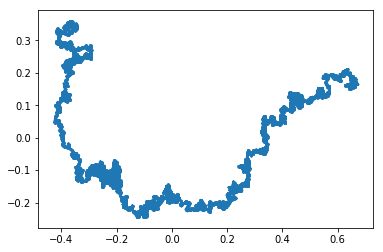

In [164]:
pca = PCA()
y = pca.fit_transform(traj[:-10])
plt.plot(y[:,0], y[:,1])
plt.scatter(y[:,0], y[:,1], s=1)

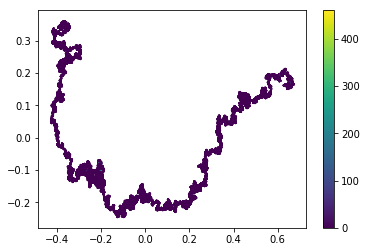

In [165]:
plt.scatter(y[:,0], y[:,1], s=1, c=energies[:-10])
plt.colorbar()

In [169]:
sampled_radii, sampled_scales = unpack_theta(traj[:-10].T)

In [170]:
sampled_radii.mean(1)

array([0.20990742, 0.09600713, 0.08747369, 0.24679001, 0.28364933,
       0.15822966, 0.1438539 , 0.20934033, 0.15909607, 0.13167446,
       0.290161  , 0.10087247, 0.09514467, 0.1754066 , 0.1262275 ,
       0.28511295, 0.10746741, 0.17035795, 0.09803335, 0.10664964,
       0.1135906 , 0.2421603 ])

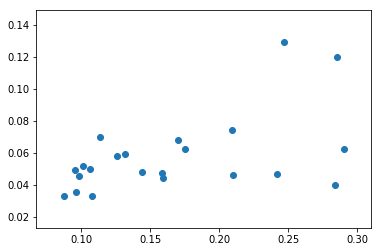

In [171]:
plt.scatter(sampled_radii.mean(1), sampled_radii.std(1))

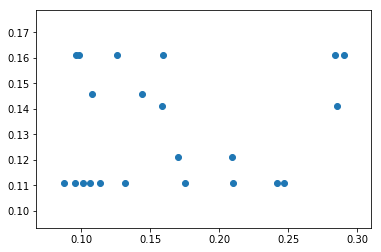

In [172]:
plt.scatter(sampled_radii.mean(1), radii)

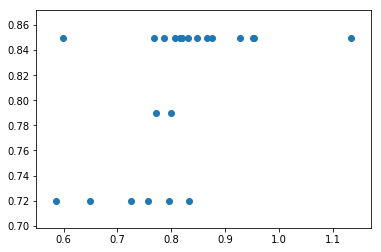

In [173]:
plt.scatter(sampled_scales.mean(1), scales)

In [174]:
from corner import corner

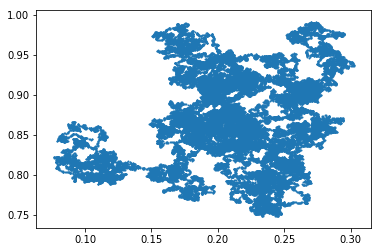

In [175]:
plt.scatter(traj[:-10,0], traj[:-10,N], s=1)

In [176]:
traj[:-10, ::5].shape

(76328, 9)

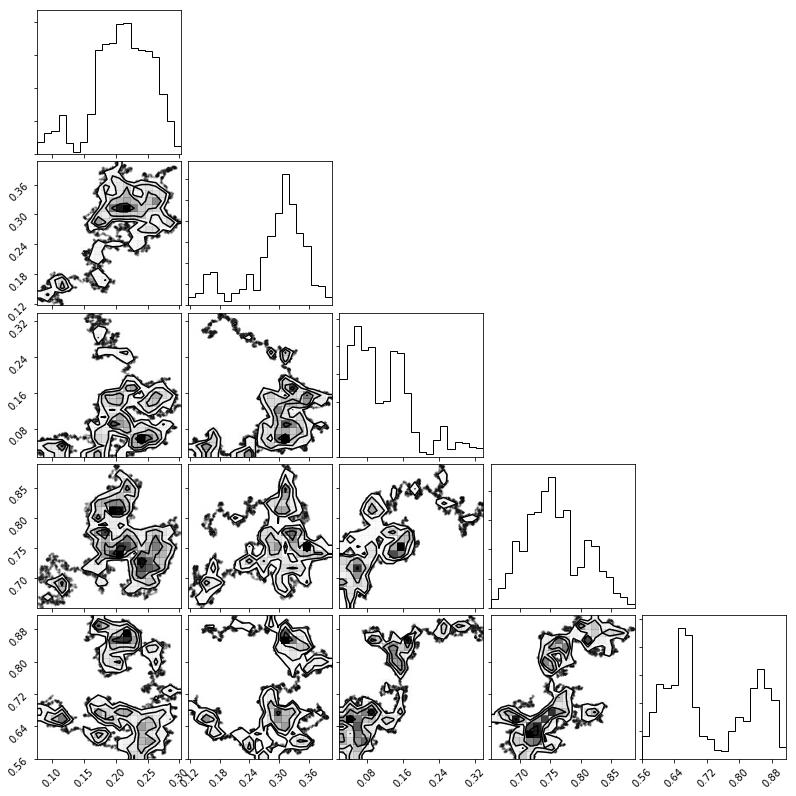

In [177]:
corner(traj[10:-10, ::10]);

In [ ]:
# question: how much can we really trust the gradients? should I "regularize" them to be flatter when outside their comfort zone?